This data comes from the [DE-SynPUF](http://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF.html) dataset, published by the United States Centers for Medicare and Medicaid Services (CMS).

### Claims Data in R

In [1]:
Claims = read.csv('./dataset/ClaimsData.csv')
str(Claims)

'data.frame':	458005 obs. of  16 variables:
 $ age              : int  85 59 67 52 67 68 75 70 67 67 ...
 $ alzheimers       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ arthritis        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ cancer           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ copd             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ depression       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ diabetes         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ heart.failure    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ihd              : int  0 0 0 0 0 0 0 0 0 0 ...
 $ kidney           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ osteoporosis     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ stroke           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ reimbursement2008: int  0 0 0 0 0 0 0 0 0 0 ...
 $ bucket2008       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ reimbursement2009: int  0 0 0 0 0 0 0 0 0 0 ...
 $ bucket2009       : int  1 1 1 1 1 1 1 1 1 1 ...


In [2]:
table(Claims$bucket2009) / nrow(Claims)


          1           2           3           4           5 
0.671267781 0.190170413 0.089466272 0.043324855 0.005770679 

In [3]:
library('caTools')

In [4]:
set.seed(88)

In [5]:
spl = sample.split(Claims$bucket2009, SplitRatio = 0.6)

In [6]:
ClaimsTrain = subset(Claims, spl == TRUE)
ClaimsTest = subset(Claims, spl == FALSE)

#### Quick Question

In [7]:
mean(ClaimsTrain$age)

[1] 72.63773

In [8]:
had_diabetes = subset(ClaimsTrain, diabetes > 0)
nrow(had_diabetes) / nrow(ClaimsTrain)

[1] 0.3808983

or

In [9]:
table(ClaimsTrain$diabetes) / nrow(ClaimsTrain)


        0         1 
0.6191017 0.3808983 

### Baseline Method and Penalty Matrix

In [10]:
table(ClaimsTest$bucket2009, ClaimsTest$bucket2008)

   
         1      2      3      4      5
  1 110138   7787   3427   1452    174
  2  16000  10721   4629   2931    559
  3   7006   4629   2774   1621    360
  4   2688   1943   1415   1539    352
  5    293    191    160    309    104

In [11]:
accuracy = (110138 + 10721 + 2774 + 1539 + 104) / nrow(ClaimsTest)
accuracy

[1] 0.6838135

In [12]:
PenaltyMatrix = matrix(c(0, 1, 2, 3, 4, 
                         2, 0, 1, 2, 3, 
                         4, 2, 0, 1, 2, 
                         6 ,4 ,2, 0, 1,
                         8, 6, 4, 2, 0), byrow=TRUE, nrow=5)

In [13]:
PenaltyMatrix

0,1,2,3,4
2,0,1,2,3
4,2,0,1,2
6,4,2,0,1
8,6,4,2,0


In [14]:
as.matrix(table(ClaimsTest$bucket2009, ClaimsTest$bucket2008)) * PenaltyMatrix

   
        1     2     3     4     5
  1     0  7787  6854  4356   696
  2 32000     0  4629  5862  1677
  3 28024  9258     0  1621   720
  4 16128  7772  2830     0   352
  5  2344  1146   640   618     0

In [15]:
sum(as.matrix(table(ClaimsTest$bucket2009, ClaimsTest$bucket2008)) * PenaltyMatrix) / nrow(ClaimsTest)

[1] 0.7386055

#### Quick Question

Suppose that instead of the baseline method discussed in the previous video, we used the baseline method of predicting the most frequent outcome for all observations. This new baseline method would predict cost bucket 1 for everyone.

In [16]:
table(ClaimsTest$bucket2009)


     1      2      3      4      5 
122978  34840  16390   7937   1057 

In [17]:
122978 / nrow(ClaimsTest)

[1] 0.67127

In [18]:
sum(as.matrix(table(ClaimsTest$bucket2009)) * PenaltyMatrix[, 1]) /nrow(ClaimsTest)

[1] 1.044301

### Predicting Healthcare Costs in R

In [19]:
library("rpart")
library("rpart.plot")

In [20]:
ClaimsTree = rpart(bucket2009 ~ age + arthritis + alzheimers + cancer + copd + depression + 
                  diabetes + heart.failure + ihd + kidney + osteoporosis + stroke +
                  bucket2008 + reimbursement2008, data= ClaimsTrain, method="class", cp=0.00005)

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”


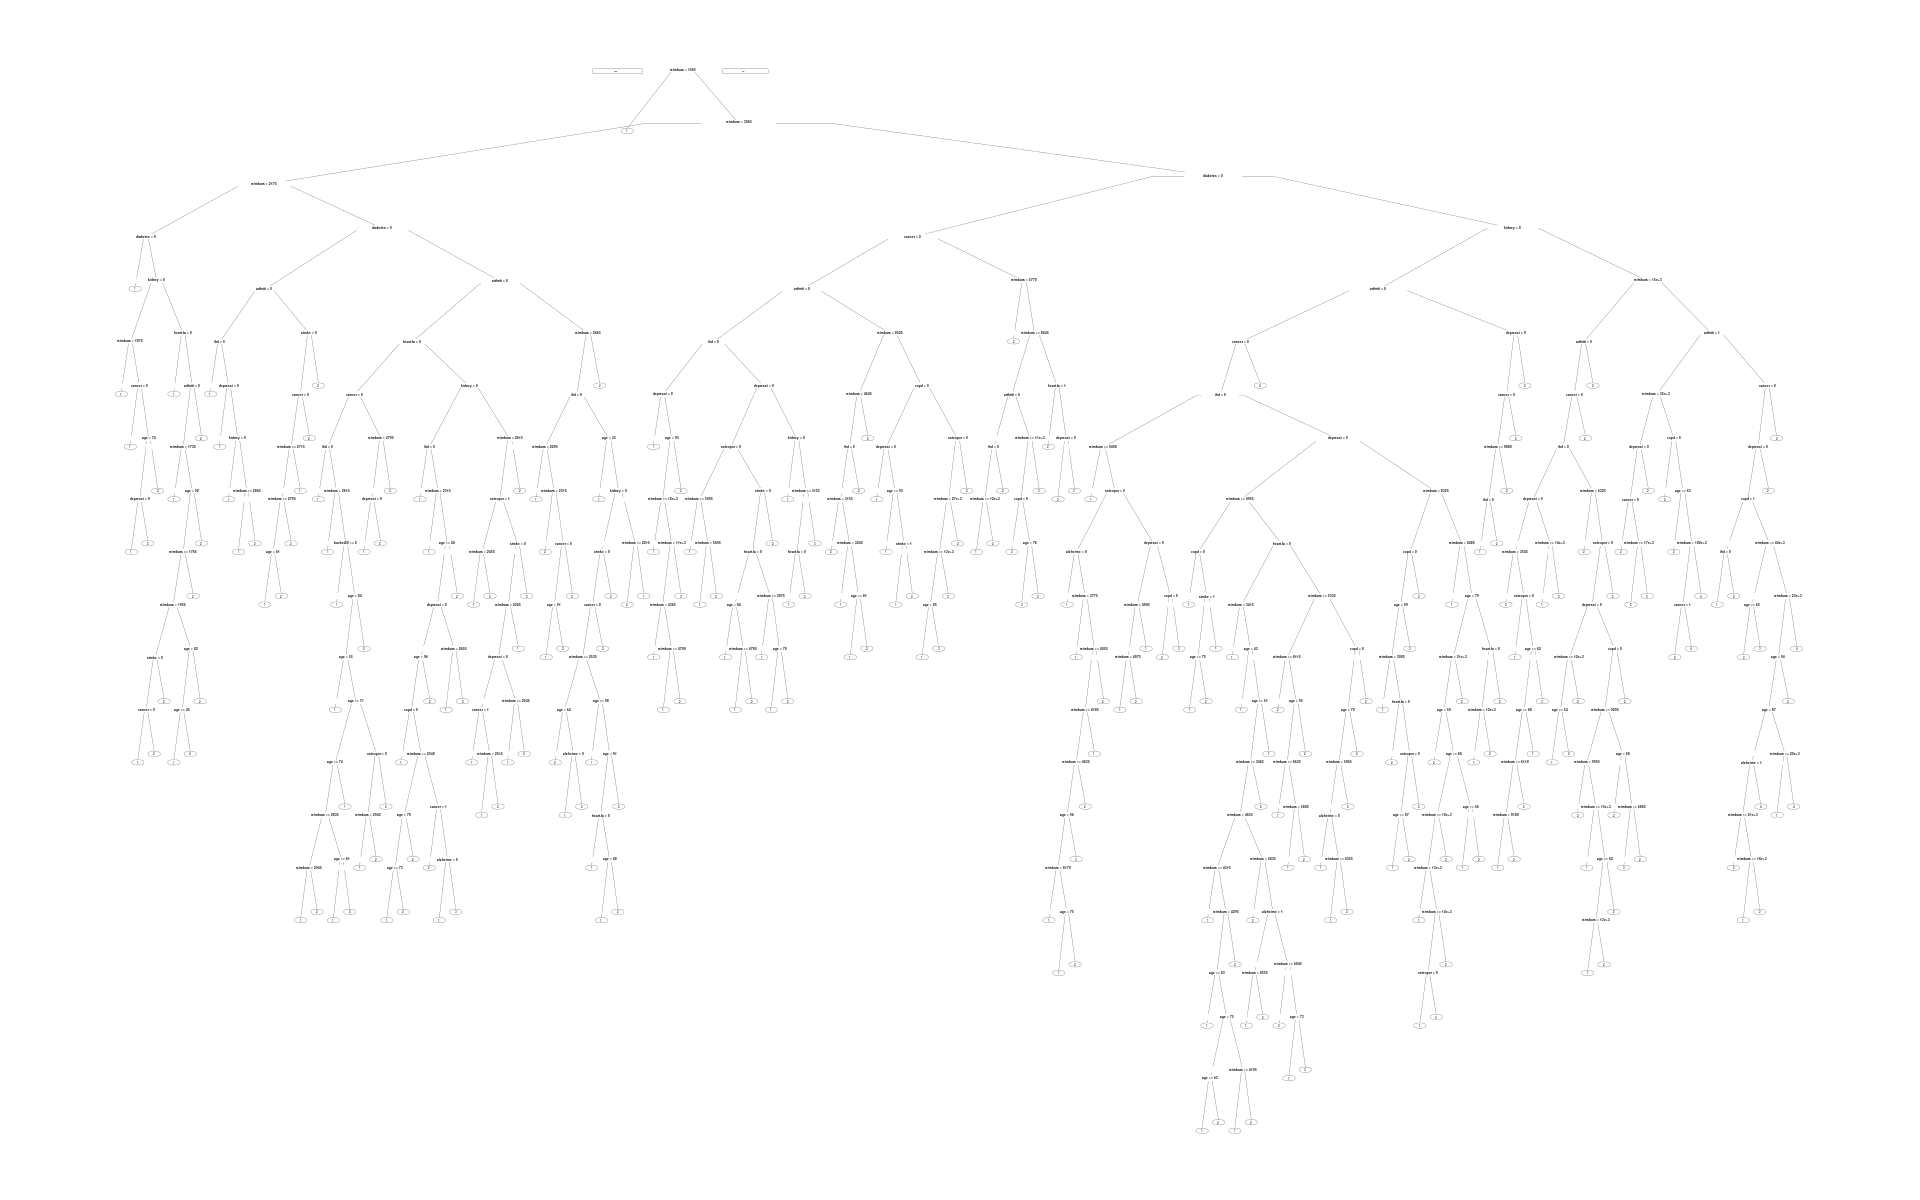

In [24]:
options(repr.plot.width=16, repr.plot.height=10)
prp(ClaimsTree)

In [25]:
PredictTest = predict(ClaimsTree, newdata=ClaimsTest, type='class')

In [26]:
table(ClaimsTest$bucket2009, PredictTest)

   PredictTest
         1      2      3      4      5
  1 114141   8610    124    103      0
  2  18409  16102    187    142      0
  3   8027   8146    118     99      0
  4   3099   4584     53    201      0
  5    351    657      4     45      0

In [27]:
accuracy = (114141 + 16102 + 118 + 201 + 0) / nrow(ClaimsTest)
accuracy

[1] 0.7126669

In [28]:
as.matrix(table(ClaimsTest$bucket2009, PredictTest)) * PenaltyMatrix

   PredictTest
        1     2     3     4     5
  1     0  8610   248   309     0
  2 36818     0   187   284     0
  3 32108 16292     0    99     0
  4 18594 18336   106     0     0
  5  2808  3942    16    90     0

In [29]:
sum(as.matrix(table(ClaimsTest$bucket2009, PredictTest)) * PenaltyMatrix) / nrow(ClaimsTest)

[1] 0.7578902

In [30]:
ClaimsTree1 = rpart(bucket2009 ~ age + arthritis + alzheimers + cancer + copd + depression + 
                  diabetes + heart.failure + ihd + kidney + osteoporosis + stroke +
                  bucket2008 + reimbursement2008, data= ClaimsTrain, method="class", 
                    cp=0.00005, parms=list(loss=PenaltyMatrix))

In [33]:
PredictTest1 = predict(ClaimsTree1, newdata=ClaimsTest, type="class")

In [34]:
table(ClaimsTest$bucket2009, PredictTest1)

   PredictTest1
        1     2     3     4     5
  1 94310 25295  3087   286     0
  2  7176 18942  8079   643     0
  3  3590  7706  4692   401     1
  4  1304  3193  2803   636     1
  5   135   356   408   156     2

In [35]:
accuracy = (94310 + 18942 + 4692 + 636 + 2) / nrow(ClaimsTest)
accuracy

[1] 0.6472746

In [36]:
penalty_error = sum(as.matrix(table(ClaimsTest$bucket2009, PredictTest1)) * PenaltyMatrix) / nrow(ClaimsTest)
penalty_error

[1] 0.6418161